In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = np.expand_dims(x_train, -1) / 255.
x_test = np.expand_dims(x_test, -1) / 255.

In [4]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPool2D(strides=2))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(120, activation='relu'))
model.add(tf.keras.layers.Dense(84, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [5]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

In [6]:
def gen_random_batch(in_groups, batch_halfsize):
    '''Created batches with batch_halfsize size for each class for each true and false match
    true matches are supposed to have 1 score and false matches score 0'''

    out_img_a, out_img_b, out_score = [], [], []
    # get groups numbers
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        # generate random indices of classes
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        # choose for each class in group_idx random image
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            b_group_idx= [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            out_score += [0]*batch_halfsize
        # image b is the right one
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return (np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0))

In [7]:
x = model.layers[-2].output 
o = tf.keras.layers.Dense(64)(x)
feature_model = tf.keras.models.Model(inputs = model.input, outputs = o)

In [8]:
img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = tf.keras.layers.concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = tf.keras.layers.Dense(16, activation = 'linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(4, activation = 'linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = tf.keras.models.Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 64)           64664       ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 128)          0           ['model[0][0]',   

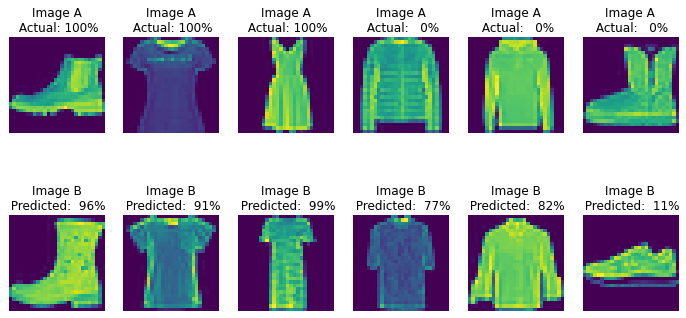

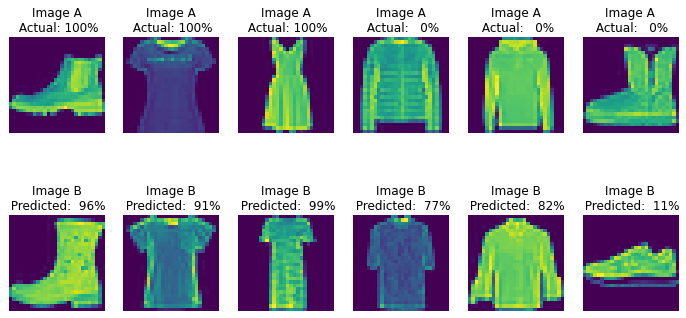

In [13]:
def show_model_output(nb_examples = 3):
    '''Visualised model on test set on random batch'''
    # gets random batches of images a and b and gets the right scores of it pv_sim
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    # get preditions of simislarity model
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

show_model_output()

Epoch 1/5
512/512 [==============================] - 67s 129ms/step - loss: 0.4554 - accuracy: 0.8054 - val_loss: 0.3616 - val_accuracy: 0.8423
Epoch 2/5
512/512 [==============================] - 59s 116ms/step - loss: 0.2921 - accuracy: 0.8765 - val_loss: 0.2548 - val_accuracy: 0.8921
Epoch 3/5
512/512 [==============================] - 59s 116ms/step - loss: 0.2526 - accuracy: 0.8902 - val_loss: 0.2275 - val_accuracy: 0.9058
Epoch 4/5
512/512 [==============================] - 59s 116ms/step - loss: 0.2255 - accuracy: 0.9064 - val_loss: 0.2241 - val_accuracy: 0.9067
Epoch 5/5
512/512 [==============================] - 60s 116ms/step - loss: 0.2133 - accuracy: 0.9117 - val_loss: 0.2223 - val_accuracy: 0.9087


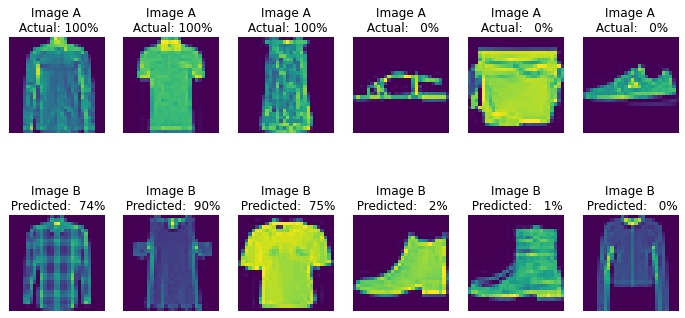

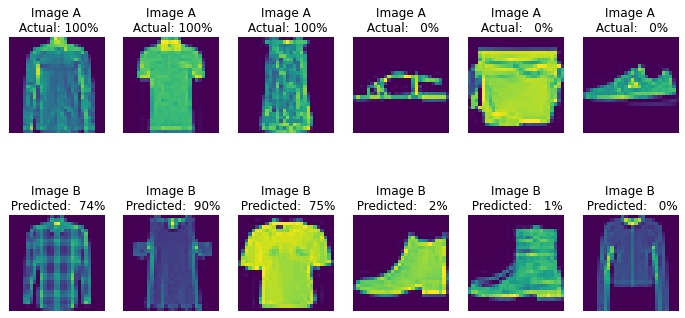

In [10]:
def siam_gen(in_groups, batch_size):
    '''Generator for a and b images'''
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups, batch_size=64), steps_per_epoch = 512,validation_data=([valid_a, valid_b], valid_sim), 
                                    epochs = 5, verbose = 1)
show_model_output()

In [14]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [15]:
first_img = 'Bag'
sec_img = 'Dress'

first_vec = np.stack([train_groups[obj_categories.index(first_img)][0]]*x_test.shape[0],0)
first_score = similarity_model.predict([first_vec, x_test], verbose = 1, batch_size = 128)
sec_vec = np.stack([train_groups[obj_categories.index(sec_img)][0]]*x_test.shape[0],0)
sec_score = similarity_model.predict([sec_vec, x_test], verbose = 1, batch_size = 128)

79/79 [==============================] - 3s 33ms/step


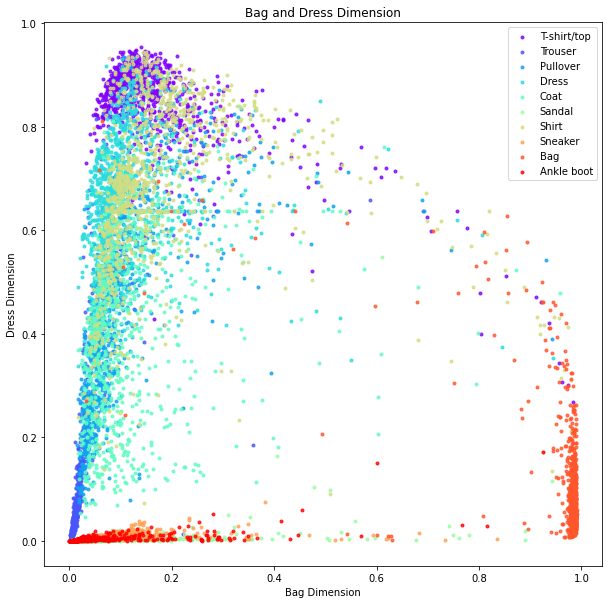

In [16]:
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(first_score[np.where(y_test == c_group), 0],
                sec_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel(f'{first_img} Dimension')
plt.ylabel(f'{sec_img} Dimension')
plt.title(f'{first_img} and {sec_img} Dimension')
plt.legend(loc='best')
plt.show(block=False)

In [17]:
x_test_features = feature_model.predict(x_test, verbose = 1, batch_size=128)

79/79 [==============================] - 1s 18ms/step


In [18]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.595s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.093915
[t-SNE] Computed conditional probabilities in 0.534s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 76.5919113, gradient norm = 0.0044118 (50 iterations in 4.105s)
[t-SNE] Iteration 100: error = 73.9802094, gradient norm = 0.0025148 (50 iterations in 3.995s)
[t-SNE] Iteration 150: error = 72.7363510, gradient norm = 0.0017012 (50 iterations in 4.012s)
[t-SNE] Iteration 200: error = 72.1109924, gradient norm = 0.0012044 (50 iterations in 4.105s)
[t-SNE] Iteration 250: error = 71.7333145, gradient norm = 0.0009309 (50 iterations in 4.017s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.733315
[t-SNE] Iteration 300: error = 2.5145574, gradient norm = 0.0012992 (50 iterations in 4.217s)
[t-SNE] Iteration 350: error = 2.0104010, gradient norm = 0.0005879 (50 iterations in 4.043s)
[t-SNE] Iteration 400: error = 1.7670002, gradient norm = 0.0003468 (50 iterations in 4.016s)
[t-SNE] Iteration 450: error = 1.6235607, gradient norm = 0.0002376 (50 iterations in 4.027s)
[t-SNE] Iteration 500: error = 1.5288606, gradient norm = 0.0001767 (50 

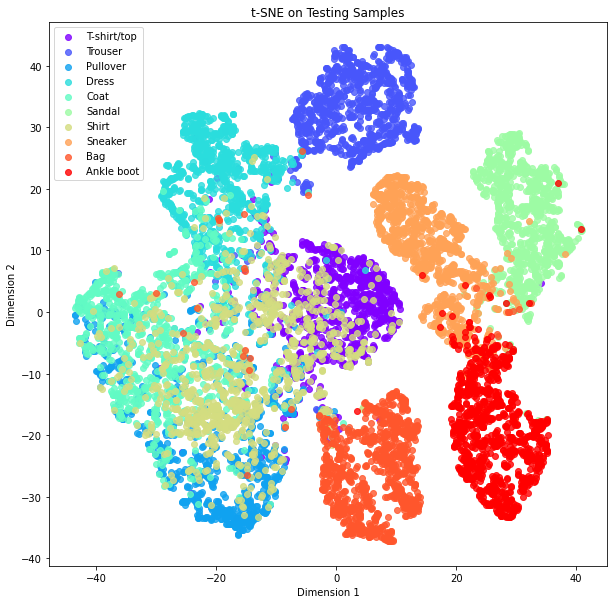

In [19]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'  ] 
colors = plt.cm.rainbow(np.linspace(0, 1, 10)) 
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(tsne_features[np.where(y_test == c_group), 0],  tsne_features[np.where(y_test == c_group), 1],  marker='o', 
  color=c_color, 
  linewidth='1', 
  alpha=0.8, 
  label=c_label) 
plt.xlabel('Dimension 1') 
plt.ylabel('Dimension 2') 
plt.title('t-SNE on Testing Samples') 
plt.legend(loc='best')  
plt.show(block=False)